# Import Libraries & Pre-Processing

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2022-07-15 17:26:37.921175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alex/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-15 17:26:37.921195: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import PIL.Image

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Downloading & Prepping Dataset

In [5]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
    )

2022-07-15 17:28:19.573233: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2022-07-15 17:28:25.800448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 17:28:25.800714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alex/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-15 17:28:25.800752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alex/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-15 17:28:25.800782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: lib

In [6]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1

In [11]:
print(f"Total Classes: {num_classes} Total Training Images: {num_training_examples} Total Validation Images {num_validation_examples}")

Total Classes: 5 Total Training Images: 2569 Total Validation Images 1101


The images within the our dataset are all of differing sizes as can be seen

In [12]:
for i, example in enumerate(training_set.take(5)):
    print(f"Image {i+1} shape: {example[0].shape} label {example[1]}")

Image 1 shape: (333, 500, 3) label 2
Image 2 shape: (212, 320, 3) label 3
Image 3 shape: (240, 320, 3) label 3
Image 4 shape: (240, 320, 3) label 4
Image 5 shape: (317, 500, 3) label 3


#### Function for Re-formatting the Images

In [16]:
# MobileNet expects images of 224 x 224
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

This cell below creates training and validation batches of size 32

In [17]:
BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image) \
                .batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Training Transferred Model

We will be using the entire pre-trained model except for the last layer as we want the model to classify a different set of classes than what it was trained on. By doing this our model has already done the bulk of the work in identifying the image except for creating the final probability distribution.

In [19]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
IMAGE_RES = (224,224,3)
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=IMAGE_RES)


### Freezing the Pre-Trained Model

In [20]:
feature_extractor.trainable = False

### Adding Ouput Classification Layer

In [21]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


# Training the Model

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 34s 405ms/step - loss: 0.7886 - accuracy: 0.7104 - val_loss: 0.4655 - val_accuracy: 0.8347
Epoch 2/6
81/81 [==============================] - 32s 395ms/step - loss: 0.3864 - accuracy: 0.8727 - val_loss: 0.3653 - val_accuracy: 0.8810
Epoch 3/6
81/81 [==============================] - 33s 413ms/step - loss: 0.2969 - accuracy: 0.9023 - val_loss: 0.3335 - val_accuracy: 0.8892
Epoch 4/6
81/81 [==============================] - 31s 387ms/step - loss: 0.2534 - accuracy: 0.9190 - val_loss: 0.3070 - val_accuracy: 0.8983
Epoch 5/6
81/81 [==============================] - 30s 372ms/step - loss: 0.2191 - accuracy: 0.9342 - val_loss: 0.2969 - val_accuracy: 0.8992
Epoch 6/6
81/81 [==============================] - 31s 378ms/step - loss: 0.1892 - accuracy: 0.9439 - val_loss: 0.2919 - val_accuracy: 0.9019


Our validation set gets 90% accuracy which is due to the performance of MobileNet v2

# Training and Validation Graphs

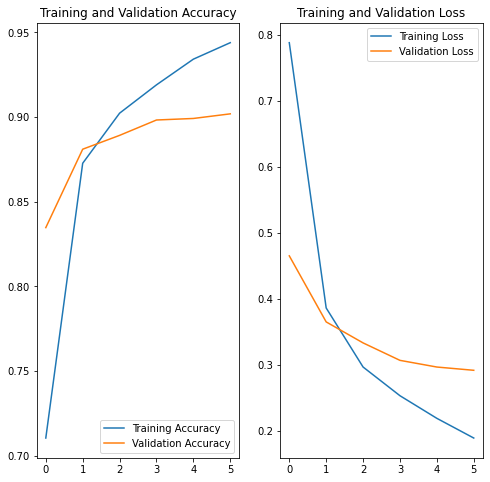

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Checking Predictions

In [24]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

### Create Image Batch to make Predictions

In [25]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 492ms/step
['sunflowers' 'sunflowers' 'tulips' 'dandelion' 'tulips' 'roses' 'roses'
 'roses' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'tulips' 'daisy'
 'roses' 'dandelion' 'daisy' 'roses' 'sunflowers' 'daisy' 'dandelion'
 'daisy' 'dandelion' 'sunflowers' 'dandelion' 'daisy' 'tulips'
 'sunflowers' 'daisy' 'daisy' 'tulips' 'dandelion']


## Compare with True Labels

In [26]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [3 3 2 0 2 4 4 4 0 1 3 2 2 1 4 0 1 4 3 1 0 1 0 3 0 1 2 3 1 1 2 0]
Predicted labels:  [3 3 2 0 2 4 4 4 0 1 3 2 2 1 4 0 1 4 3 1 0 1 0 3 0 1 2 3 1 1 2 0]


## Plotting Model Predictions

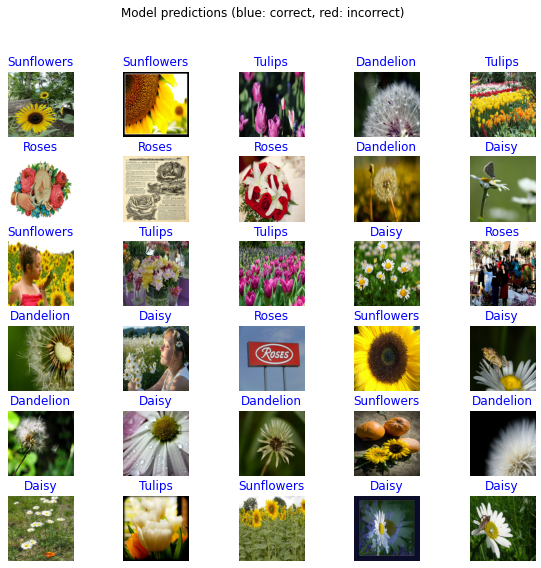

In [27]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")